# Content based recommendation system

## Background

## Set-up

### Dependencies

In [1]:
import inspect
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random

import sys
sys.path.insert(0, "C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\book-content-based-recommender\\book-content-based-recommender")
import custom_funcs as cf

### Import data

Dataset source: https://github.com/zygmuntz/goodbooks-10k

In [2]:
books = pd.read_csv('../data/raw/books.csv')
to_read = pd.read_csv('../data/raw/to_read.csv')
ratings = pd.read_csv('../data/raw/ratings.csv')
book_tags = pd.read_csv('../data/raw/book_tags.csv')
tags = pd.read_csv('../data/raw/tags.csv')

## Data exploration

Note on book identifiers:

* Each book may have many editions.  **_goodreads_book_id_** and **_best_book_id_** generally point to the most popular edition of a given book, while goodreads  **_work_id_** refers to the book in the abstract sense. 

* Note that _book_id_ in **ratings.csv** and **to_read.csv** maps to **_work_id_**, not to **_goodreads_book_id_**, meaning that ratings for different editions are aggregated.

### books

In [3]:
# Dimensions
print(f"Number of records: {books.shape[0]}")
print(f"Number of columns: {books.shape[1]}")
books.head(2)

Number of records: 10000
Number of columns: 23


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [4]:
# Data types
display(books.dtypes.value_counts())
print("\n")
books.dtypes

int64      13
object      7
float64     3
Name: count, dtype: int64

book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                         object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
image_url                     object
small_image_url               object
dtype: object

In [5]:
# Missing values
books.isnull().sum()[(books.isnull().sum() > 1)]

isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64

In [6]:
# Duplicate values
books[books.duplicated()]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url


In [7]:
# Number of unique value per columns
books.nunique()

book_id                      10000
goodreads_book_id            10000
best_book_id                 10000
work_id                      10000
books_count                    597
isbn                          9300
isbn13                        9153
authors                       4664
original_publication_year      293
original_title                9274
title                         9964
language_code                   25
average_rating                 184
ratings_count                 9003
work_ratings_count            9053
work_text_reviews_count       4581
ratings_1                     2630
ratings_2                     4117
ratings_3                     6972
ratings_4                     7762
ratings_5                     8103
image_url                     6669
small_image_url               6669
dtype: int64

In [8]:
books[['average_rating', 'work_ratings_count']].describe()

,average_rating,work_ratings_count
count,10000.000000,1.000000e+04
mean,4.002191,5.968732e+04
std,0.254427,1.678038e+05
min,2.470000,5.510000e+03
25%,3.850000,1.543875e+04
50%,4.020000,2.383250e+04
75%,4.180000,4.591500e+04
max,4.820000,4.942365e+06


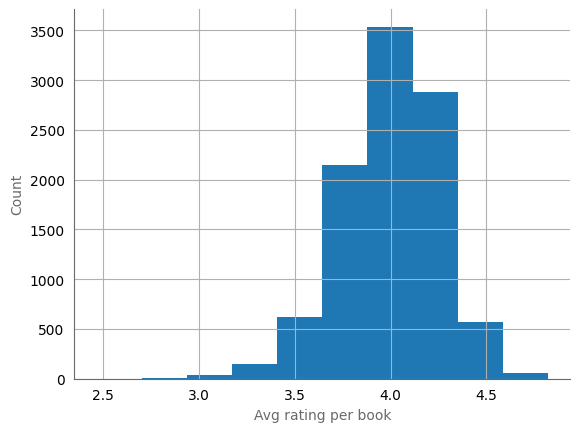

In [9]:
# Average rating per book
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Avg rating per book', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(books['average_rating']);

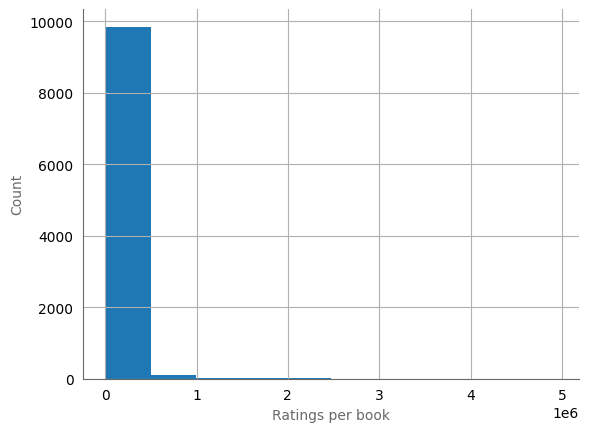

In [10]:
# Average rating per book
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Ratings per book', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(books['work_ratings_count']);

### ratings

In [11]:
# Dimensions
print(f"Number of records: {ratings.shape[0]}")
print(f"Number of columns: {ratings.shape[1]}")
ratings.head(2)

Number of records: 5976479
Number of columns: 3


,user_id,book_id,rating
0,1,258,5
1,2,4081,4


In [12]:
# Data types
display(ratings.dtypes.value_counts())
print("\n")
ratings.dtypes

int64    3
Name: count, dtype: int64

user_id    int64
book_id    int64
rating     int64
dtype: object

In [13]:
# Missing values
ratings.isnull().sum()[(ratings.isnull().sum() > 1)]

Series([], dtype: int64)

In [14]:
# Duplicate values
ratings[ratings.duplicated()]

,user_id,book_id,rating


In [15]:
# Number of ratings per user
ratings_per_user = ratings.groupby("user_id")["rating"].count().sort_values()
ratings_per_user.describe()

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: rating, dtype: float64

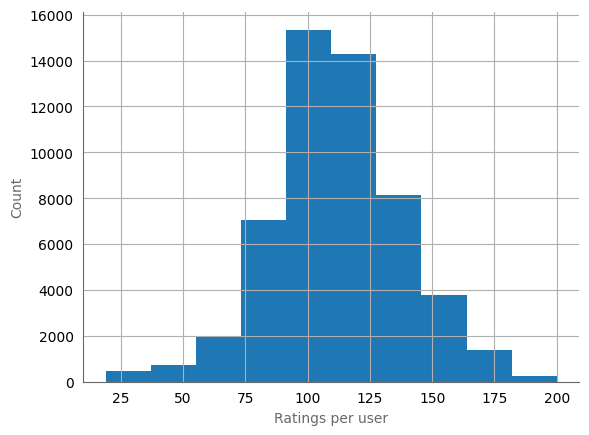

In [16]:
# Number of ratings per user
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Ratings per user', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(ratings_per_user);

### to read

In [17]:
# Dimensions
print(f"Number of records: {to_read.shape[0]}")
print(f"Number of columns: {to_read.shape[1]}")
to_read.head(2)

Number of records: 912705
Number of columns: 2


,user_id,book_id
0,9,8
1,15,398


In [18]:
# Data types
display(to_read.dtypes.value_counts())
print("\n")
to_read.dtypes

int64    2
Name: count, dtype: int64

user_id    int64
book_id    int64
dtype: object

In [19]:
# Missing values
to_read.isnull().sum()[(to_read.isnull().sum() > 1)]

Series([], dtype: int64)

In [20]:
# Duplicate values
to_read[to_read.duplicated()]

,user_id,book_id


In [21]:
# To read per user
toread_per_user = to_read.groupby("user_id")["book_id"].count().sort_values()
toread_per_user.describe()

count    48871.000000
mean        18.675800
std         16.089767
min          1.000000
25%          6.000000
50%         14.000000
75%         27.000000
max        117.000000
Name: book_id, dtype: float64

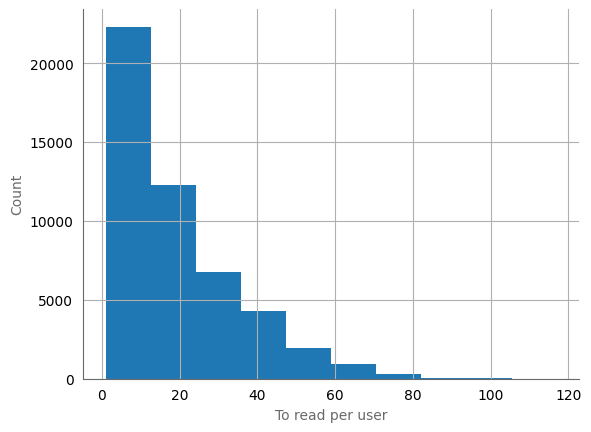

In [22]:
# Number of books to read per user
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('To read per user', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(toread_per_user);

### book tags

In [23]:
# Dimensions
print(f"Number of records: {book_tags.shape[0]}")
print(f"Number of columns: {book_tags.shape[1]}")
book_tags.head(2)

Number of records: 999912
Number of columns: 3


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174


In [24]:
# Data types
display(book_tags.dtypes.value_counts())
print("\n")
book_tags.dtypes

int64    3
Name: count, dtype: int64

goodreads_book_id    int64
tag_id               int64
count                int64
dtype: object

In [25]:
# Missing values
book_tags.isnull().sum()[(book_tags.isnull().sum() > 1)]

Series([], dtype: int64)

In [26]:
# Duplicate values
book_tags[book_tags.duplicated()]

,goodreads_book_id,tag_id,count
159371,22369,25148,4
265128,52629,10094,1
265140,52629,2928,1
265155,52629,13272,1
265187,52629,13322,1
308771,77449,25148,7


In [27]:
# Remove duplicates
book_tags = book_tags.loc[book_tags.duplicated() == False, :]

In [28]:
# Number of tags per book
tags_per_book = book_tags.groupby("goodreads_book_id")["tag_id"].count().sort_values()
tags_per_book.describe()

count    10000.000000
mean        99.990600
std          0.585957
min         56.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: tag_id, dtype: float64

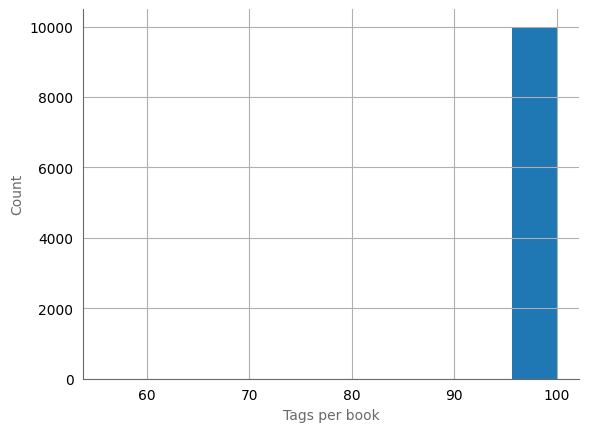

In [29]:
# Number of tags per book
fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlabel('Tags per book', fontsize=10, color='dimgray')
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.hist(tags_per_book);

### tags

In [30]:
# Dimensions
print(f"Number of records: {tags.shape[0]}")
print(f"Number of columns: {tags.shape[1]}")
tags.head(2)

Number of records: 34252
Number of columns: 2


,tag_id,tag_name
0,0,-
1,1,--1-


In [31]:
# Data types
display(tags.dtypes.value_counts())
print("\n")
tags.dtypes

int64     1
object    1
Name: count, dtype: int64

tag_id       int64
tag_name    object
dtype: object

In [32]:
# Missing values
tags.isnull().sum()[(tags.isnull().sum() > 1)]

Series([], dtype: int64)

In [33]:
# Duplicate values
tags[tags.duplicated()]

,tag_id,tag_name


## Pre-processing

### Decodes

In [34]:
# Add tag names to book tags df
print(f"Shape before join: {book_tags.shape}")
book_tags = book_tags.merge(tags, on="tag_id", how="left", suffixes=('', '_remove'))
book_tags = book_tags.drop([col for col in book_tags.columns if 'remove' in col], axis=1)
print(f"Shape after join: {book_tags.shape}")
print(f"\nMissing values :\n{book_tags.isna().sum()}")
display(book_tags.head())

Shape before join: (999906, 3)
Shape after join: (999906, 4)

Missing values :
goodreads_book_id    0
tag_id               0
count                0
tag_name             0
dtype: int64


,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult


In [35]:
# Aggregate tag names by goodreads_book_id
tag_name_lookup = book_tags.groupby("goodreads_book_id")["tag_name"].apply(list).rename("book_tags")
tag_name_lookup = tag_name_lookup.apply(lambda x: " ".join(list(x)))
tag_name_lookup = tag_name_lookup.reset_index()
print(f"Tag name lookup shape: {tag_name_lookup.shape}")
print(f"Missing book tags :\n{tag_name_lookup['book_tags'].isna().sum()}")
display(tag_name_lookup.head())

Tag name lookup shape: (10000, 2)
Missing book tags :
0


,goodreads_book_id,book_tags
0,1,to-read fantasy favorites currently-reading yo...
1,2,to-read currently-reading fantasy favorites ch...
2,3,to-read favorites fantasy currently-reading yo...
3,5,favorites fantasy currently-reading young-adul...
4,6,fantasy young-adult fiction harry-potter owned...


In [36]:
# Add aggregated tag names to books df
print(f"Shape before join: {books.shape}")
books = books.merge(tag_name_lookup, on="goodreads_book_id", how="left", suffixes=('', '_remove'))
books = books.drop([col for col in books.columns if 'remove' in col], axis=1)
print(f"Shape after join: {books.shape}")
print(f"Missing book tags :\n{books['book_tags'].isna().sum()}")
display(books[["goodreads_book_id", "book_tags"]].head())

Shape before join: (10000, 23)
Shape after join: (10000, 24)
Missing book tags :
0


,goodreads_book_id,book_tags
0,2767052,favorites currently-reading young-adult fictio...
1,3,to-read favorites fantasy currently-reading yo...
2,41865,young-adult fantasy favorites vampires ya fict...
3,2657,classics favorites to-read classic historical-...
4,4671,classics favorites fiction classic books-i-own...


In [37]:
# Add book title and tag names to ratings
print(f"Shape before join: {ratings.shape}")
ratings = ratings.merge(books[["book_id", "title", "authors", "book_tags"]], left_on="book_id", right_on="book_id", how="left", suffixes=("", "_remove"))
ratings = ratings.drop([col for col in ratings.columns if "remove" in col], axis=1)

print(f"Shape after join: {ratings.shape}")
print(f"Missing values :\n{ratings.isna().sum()}")
display(ratings.head())

Shape before join: (5976479, 3)
Shape after join: (5976479, 6)
Missing values :
user_id      0
book_id      0
rating       0
title        0
authors      0
book_tags    0
dtype: int64


,user_id,book_id,rating,title,authors,book_tags
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...,"Carlos Ruiz Zafón, Lucia Graves",to-read currently-reading favorites fiction hi...
1,2,4081,4,I am Charlotte Simmons,Tom Wolfe,to-read fiction currently-reading favorites ow...
2,2,260,5,How to Win Friends and Influence People,Dale Carnegie,non-fiction to-read self-improvement nonfictio...
3,2,9296,5,The Drama of the Gifted Child: The Search for ...,"Alice Miller, Ruth Ward",to-read psychology non-fiction nonfiction self...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...,"Thomas J. Stanley, William D. Danko",to-read currently-reading non-fiction finance ...


In [38]:
# Add book title and tag names to to_read
print(f"Shape before join: {to_read.shape}")
to_read = to_read.merge(books[["book_id", "title", "authors", "book_tags"]], left_on="book_id", right_on="book_id", how="left", suffixes=("", "_remove"))
to_read = to_read.drop([col for col in to_read.columns if "remove" in col], axis=1)
print(f"Shape after join: {to_read.shape}")
print(f"Missing values :\n{to_read.isna().sum()}")
display(to_read.head())

Shape before join: (912705, 2)
Shape after join: (912705, 5)
Missing values :
user_id      0
book_id      0
title        0
authors      0
book_tags    0
dtype: int64


,user_id,book_id,title,authors,book_tags
0,9,8,The Catcher in the Rye,J.D. Salinger,classics favorites fiction to-read classic you...
1,15,398,Fast Food Nation: The Dark Side of the All-Ame...,Eric Schlosser,to-read non-fiction nonfiction currently-readi...
2,15,275,An Abundance of Katherines,John Green,currently-reading young-adult to-read favorite...
3,37,7173,Musashi,"Eiji Yoshikawa, Charles Terry, Edwin O. Reisch...",to-read currently-reading fiction historical-f...
4,34,380,Norwegian Wood,"Haruki Murakami, Jay Rubin",to-read currently-reading favorites fiction ja...


### Book profiles

**Title-author-tags**

The feature representations of each book are created using the title, author and tags.

In [39]:
# Create book id-tag lookup
book_profile = books.groupby("book_id")[["title", "authors", "book_tags"]].first()
book_profile["book_profile"] = book_profile["title"] + " " + book_profile["authors"] + " " + book_profile["book_tags"].fillna(" ")
book_profile["book_profile"] = book_profile["book_profile"].str.lower()
print(f"Shape: {book_profile.shape}")
print(f"Missing values :\n{book_profile.isna().sum()}")
display(book_profile.head())

Shape: (10000, 4)
Missing values :
title           0
authors         0
book_tags       0
book_profile    0
dtype: int64


,title,authors,book_tags,book_profile
book_id,,,,
1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,favorites currently-reading young-adult fictio...,"the hunger games (the hunger games, #1) suzann..."
2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",to-read favorites fantasy currently-reading yo...,harry potter and the sorcerer's stone (harry p...
3,"Twilight (Twilight, #1)",Stephenie Meyer,young-adult fantasy favorites vampires ya fict...,"twilight (twilight, #1) stephenie meyer young-..."
4,To Kill a Mockingbird,Harper Lee,classics favorites to-read classic historical-...,to kill a mockingbird harper lee classics favo...
5,The Great Gatsby,F. Scott Fitzgerald,classics favorites fiction classic books-i-own...,the great gatsby f. scott fitzgerald classics ...


In [40]:
# Add book profile to books df
print(f"Shape before join: {books.shape}")
books = books.merge(book_profile, left_on="book_id", right_on="book_id", how="left", suffixes=("", "_remove"))
books = books.drop([col for col in books.columns if "remove" in col], axis=1)
print(f"Shape after join: {books.shape}")
print(f"Missing values :\n{books.isna().sum()}")
display(books.head(2))

Shape before join: (10000, 24)
Shape after join: (10000, 25)
Missing values :
book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
book_tags                       0
book_profile                    0
dtype: int64


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,book_tags,book_profile
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,favorites currently-reading young-adult fictio...,"the hunger games (the hunger games, #1) suzann..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,to-read favorites fantasy currently-reading yo...,harry potter and the sorcerer's stone (harry p...


**Popularity ranking**

An overall popularity rank is calculated for each book using the ratings dataset and the following steps:

1. Sort & rank books by the number of ratings

2. Sort & rank books by average rating

3. Combine rankings with a weight of 0.5 for each (these weights are hyperparameters, adjust as needed)

In [41]:
# Sort & rank books by the number of ratings
books = books.sort_values(by='work_ratings_count', ascending=False)
books['popularity_rank'] = range(1, len(books) + 1)

# Sort & rank books by average rating
books = books.sort_values(by='average_rating', ascending=False)
books['quality_rank'] = range(1, len(books) + 1)

# Combine rankings (adjust weights as needed)
books["combined_rank"] = 0.75*books["popularity_rank"] + 0.25*books["quality_rank"]
books.head(2)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_3,ratings_4,ratings_5,image_url,small_image_url,book_tags,book_profile,popularity_rank,quality_rank,combined_rank
3627,3628,24812,24812,25599,14,740748475,9.780741e+12,Bill Watterson,2005.0,The Complete Calvin and Hobbes,...,693,3117,25884,https://images.gr-assets.com/books/1473064526m...,https://images.gr-assets.com/books/1473064526s...,to-read favorites comics currently-reading hum...,the complete calvin and hobbes bill watterson ...,3906,1,2929.75
3274,3275,8,8,21457576,11,439682584,9.780440e+12,"J.K. Rowling, Mary GrandPré",2003.0,NaN,...,978,3686,28210,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read favorites fantasy currently-reading ha...,"harry potter boxed set, books 1-5 (harry potte...",3505,2,2629.25


### Training/test split
* The ratings dataset will be split into a training/test set.

* Recommendations will be made for each user in the test data using user profiles constructed from the training data.

* The actual books rated by each user in the test data will be considered the ground truth during evaluation.

In [42]:
from sklearn.model_selection import train_test_split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.25, random_state=0)
train_ratings = train_ratings.reset_index(drop=True)
test_ratings = test_ratings.reset_index(drop=True)

print(f"Training set shape: {train_ratings.shape}")
# display(train_ratings.head())
print(f"Test set shape: {test_ratings.shape}")
display(test_ratings.head())

Training set shape: (4482359, 6)
Test set shape: (1494120, 6)


,user_id,book_id,rating,title,authors,book_tags
0,19082,3851,5,"The Lion's Game (John Corey, #2)",Nelson DeMille,to-read fiction thriller mystery nelson-demill...
1,7714,7228,3,In the Shadow of the Banyan,Vaddey Ratner,to-read currently-reading fiction book-club as...
2,24341,3710,5,"A Kingdom of Dreams (Westmoreland, #1)",Judith McNaught,to-read historical-romance romance favorites h...
3,53116,3459,3,Les Liaisons dangereuses,"Pierre-Ambroise Choderlos de Laclos, Douglas P...",to-read classics currently-reading fiction fav...
4,52796,1053,5,"Song of Susannah (The Dark Tower, #6)","Stephen King, Darrel Anderson",to-read fantasy stephen-king currently-reading...


## Baseline models

### Random model

Basic principle:

* A user is randomly recommended n books they haven't read.

#### Algorithm
Key steps: 

1. Exclude books already rated or marked to read by the user from recommendations

2. Randomly select the top n books for the final sample.

In [43]:
# print(inspect.getsource(cf.random_rec))

def get_random_recs(user_id, all_user_ratings, n_sample, all_books, all_user_toread):
    """
    Function to get random book recommendations for a given user profile

    Parameters:
    - user_id: User id
    - all_user_ratings: Ratings history for all users
    - n_sample: Number of recommendations to generate
    - all_books: Table containing book metadata
    - all_user_toread: To read list for all users

    Returns:
    - List of book ids recommended for user
    """
    
    # User history
    rating_history = all_user_ratings.loc[all_user_ratings["user_id"] == user_id, "book_id"].tolist()
    toread_history = all_user_toread.loc[all_user_toread["user_id"] == user_id, "book_id"].tolist()
    user_history = set(rating_history).union(set(toread_history))
    
    # Exclude books already rated by the user and in the to read list from recommendations
    user_shortlist = all_books.iloc[np.isin(all_books["book_id"], user_history) == False]

    # Randomly sample top k books
    user_recs = user_shortlist.sample(n=n_sample, random_state=0)

    return user_recs["book_id"].tolist()

In [44]:
# Example
USER_ID = 10
N_RECOMMENDATIONS = 10
books.loc[books["book_id"].isin(get_random_recs(
    USER_ID, train_ratings, N_RECOMMENDATIONS, books, to_read)), "title"].tolist()

["God's Smuggler",
 'The Better Angels of Our Nature: Why Violence Has Declined',
 'The Finding (Law of the Lycans, #5)',
 'Four to Score (Stephanie Plum, #4)',
 'Carpe Jugulum (Discworld #23; Witches #6)',
 'Crooked House',
 'Still Missing',
 'Finnikin of the Rock (Lumatere Chronicles, #1)',
 'Idoru (Bridge #2)',
 "The Cat's Table"]

#### Evaluation

Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [46]:
K_FOLDS = 3  # Number of splits for kfold cross validation
N_RECOMMENDATIONS = 10  # Number of recommendations
avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_cv_scores(
    train_ratings, K_FOLDS, N_RECOMMENDATIONS, books, to_read, get_random_recs)

print(f"precision@k: {avg_precision_at_k}")
print(f"recall@k: {avg_recall_at_k}")
print(f"mean average precision@k: {avg_map_at_k}")

precision@k: 0.001859478347685008
recall@k: 0.0006839344147552525
mean average precision@k: 0.0012000860704529733


### Popularity based model

Basic principle:

* A user is recommended the n most popular books they haven't seen.

#### Algorithm

Key steps: 

1. Exclude books already rated or marked to read by the user from recommendations

2. Sort the books in descending order by the number of ratings

3. Sort the books in descending order by quality (i.e. average rating)

4. Combine the rankings using a weighted average.

5. Select the top n books for the final sample

In [47]:
# print(inspect.getsource(cf.popularity_rec))

def get_popularity_recs(user_id, all_user_ratings, n_sample, all_books, all_user_toread):
    """
    Function to get most popular book recommendations for a given user profile

    Parameters:
    - user_id: User id
    - all_user_data: Ratings history for all users
    - n_sample: Number of recommendations to generate
    - all_books: Table containing book metadata
    - all_user_toread: To read list for all users

    Returns:
    - List of book ids recommended for user
    """

    # User history
    rating_history = all_user_ratings.loc[all_user_ratings["user_id"] == user_id, "book_id"].tolist()
    toread_history = all_user_toread.loc[all_user_toread["user_id"] == user_id, "book_id"].tolist()
    user_history = set(rating_history).union(set(toread_history))
    
    # Exclude books already rated by the user and in the to read list from recommendations
    user_shortlist = all_books.iloc[np.isin(all_books["book_id"], user_history) == False]

    # Return top k books
    user_shortlist = user_shortlist.sort_values(by='combined_rank', ascending=True)
    user_recs = user_shortlist[0:n_sample]

    return user_recs["book_id"].tolist()

In [48]:
# Example
USER_ID = 10
N_RECOMMENDATIONS = 10
books.loc[books["book_id"].isin(get_popularity_recs(
    USER_ID, train_ratings, N_RECOMMENDATIONS, books, to_read)), "title"].tolist()

['Harry Potter and the Deathly Hallows (Harry Potter, #7)',
 'A Storm of Swords (A Song of Ice and Fire, #3)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
 'The Return of the King (The Lord of the Rings, #3)',
 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
 'The Help',
 'A Game of Thrones (A Song of Ice and Fire, #1)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"]

#### Evaluation
Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [49]:
K_FOLDS = 3  # Number of splits for kfold cross validation
N_RECOMMENDATIONS = 10  # Number of recommendations
avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_cv_scores(
    train_ratings, K_FOLDS, N_RECOMMENDATIONS, books, to_read, get_popularity_recs)

print(f"precision@k: {avg_precision_at_k}")
print(f"recall@k: {avg_recall_at_k}")
print(f"mean average precision@k: {avg_map_at_k}")

precision@k: 0.06159990016223648
recall@k: 0.02226642464479392
mean average precision@k: 0.06924966918836223


Does small performance gain relative to the random model reflect coverage? The popularity based model only ever suggests the same 10 novels.

## Content based filtering recommendation system

### Model 1 - tf.idf vectorisation
Basic principle:

* Items are recommended to a given user based on their ratings and toread history and the similarity of this profile to unread books.

* The profile for each user and book is translated into feature space using tf.idf vectorisation. 

#### Feature extraction
* A vector feature representing book content is created using the book profile column.
  
* The tf.idf vectorizer is fit using the book profile column. This determines the vocab size and associated vector length when vectorising user profiles later. Any unseen terms in the user profile will not be incorporated into the vector. This is a limitation of the tf.idf approach.

In [50]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(books['book_profile'])

#### Algorithm

Key steps: 

1. Filter user ratings so only the specified user remains.

2. Create a user profile vector by concatenating books across their reading history followed by vectorisation using tf.idf

3. Calculate the similarity between the user vector and all book profile vectors

4. Sort the books in descending order by similarity

5. Exclude books already rated or marked to read by the user from recommendations

6. Select the top n books for the final sample

In [51]:
def get_content_based_recs(user_id, all_user_ratings, n_sample, all_books, all_user_toread):
    """
    Function to get content-based book recommendations for a given user profile

    Parameters:
    - user_id: User id
    - all_user_data: Ratings history for all users
    - n_sample: Number of recommendations to generate
    - all_books: Table containing book metadata
    - all_user_toread: To read list for all users

    Returns:
    - precision_at_k: List of book ids recommended for user
    """
    
    # User profile vectorisation
    user_ratings = all_user_ratings.copy()
    user_ratings = user_ratings.loc[all_user_ratings["user_id"] == user_id]
    user_ratings["book_profile"] = user_ratings["title"] + " " + user_ratings["authors"] + " " + user_ratings["book_tags"].fillna(" ")
    user_ratings["book_profile"] = user_ratings["book_profile"].str.lower()
    user_profile = " ".join(user_ratings["book_profile"].values)
    user_vector = tfidf_vectorizer.transform([user_profile])
    
    # User history
    rating_history = all_user_ratings.loc[all_user_ratings["user_id"] == user_id, "book_id"].tolist()
    toread_history = all_user_toread.loc[all_user_toread["user_id"] == user_id, "book_id"].tolist()
    user_history = set(rating_history).union(set(toread_history))

    # Calculate cosine similarities & sort
    book_user_similarities = list(enumerate(cosine_similarity(user_vector, tfidf_matrix).flatten()))
    book_user_similarities = sorted(book_user_similarities, key=lambda x: x[1], reverse=True)

    # Return books NOT in the user history
    book_user_similarities = [book_id for book_id, score in book_user_similarities if book_id not in user_history]
    book_user_similarities = book_user_similarities[0:n_sample]
    user_recs = all_books.loc[book_user_similarities, "book_id"].tolist()

    return user_recs

In [52]:
# Example
USER_ID = 12
N_RECOMMENDATIONS = 10
books.loc[books["book_id"].isin(get_content_based_recs(
    USER_ID, train_ratings, N_RECOMMENDATIONS, books, to_read)), "title"].tolist()

['The Enchantress Returns (The Land of Stories, #2)',
 'The Darkest Secret (Lords of the Underworld #7)',
 'Rule of Two (Star Wars: Darth Bane, #2)',
 'Embrace the Night (Cassandra Palmer, #3)',
 'Big Rock',
 'The Realm of Possibility',
 'Deep Down Dark: The Untold Stories of 33 Men Buried in a Chilean Mine, and the Miracle That Set Them Free',
 'The Boy Who Came Back from Heaven: A Remarkable Account of Miracles, Angels, and Life beyond This World',
 'Relish: My Life in the Kitchen',
 'Visions of Sugar Plums (Stephanie Plum, #8.5)']

#### Evaluation
Key steps:

1. Split the training set into k folds. Use k-1 folds as the training set. Use the remaining data as a validation set.

2. Apply recommendation system to each user in the validation set. Output a dictionary containing predicted items for each user.

3. Create ground truth for each user in the validation set. Output a dictionary containing actual relevant items for each user.

4. Evaluate performance on a per user basis. Output a dictionary containing the relevant metric score for each user.

5. Calculate average performance across users.

6. Repeat steps 2 - 5 k times.

In [ ]:
K_FOLDS = 3  # Number of splits for kfold cross validation
N_RECOMMENDATIONS = 10  # Number of recommendations
avg_precision_at_k, avg_recall_at_k, avg_map_at_k = cf.calculate_cv_scores(
    train_ratings, K_FOLDS, N_RECOMMENDATIONS, books, to_read, get_content_based_recs)

print(f"precision@k: {avg_precision_at_k}")
print(f"recall@k: {avg_recall_at_k}")
print(f"mean average precision@k: {avg_map_at_k}")

### Model 2 - word2vec vectorisation

#### Feature extraction

#### Algorithm

#### Evaluation

### Model 3 - BERT vectorisation

#### Feature extraction

#### Algorithm

#### Evaluation

## Item similarity model

In [ ]:
#### Item similarity based 

# # Preprocess data
# books['title'] = books['title'].str.lower()
# books['authors'] = books['authors'].str.lower()

# # Combine relevant features (book title and author) into a single column
# books['features'] = books['title'] + ' ' + books['authors']
# books.loc[0, 'features']

# # TF-IDF vectorization
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(books['features'])

# # Cosine similarities between books
# cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# def get_content_based_recommendations(book_title, books, similarity_scores, top_k):
#     """Function to get content-based book recommendations for a given book title
#     """
#     # Find the index of the book in the dataframe
#     idx = books.index[books['title'] == book_title].tolist()[0]

#     # Get the pairwise similarity scores
#     book_similarities = list(enumerate(similarity_scores[idx]))

#     # Sort books based on similarity scores
#     book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)

#     # Exclude the book itself (most similar will be the book itself)
#     book_similarities = book_similarities[1:]
    
#     # Get top k similar books
#     similar_books = book_similarities[0:top_k]
    
#     # Extract book titles
#     recommended_books = books.loc[[i for i, s in similar_books], 'title'].tolist()

#     return recommended_books

# # Example
# book_title = 'the hunger games (the hunger games, #1)'
# content_based_recommendations = get_content_based_recommendations(book_title, books, cosine_similarities, 5)

# # Display recommendations
# print(f"Content-based recommendations for '{book_title}':\n")
# for i, title in enumerate(content_based_recommendations):
#     print(i+1, title)